# Training an LSTM model on books dataset

First we import necessary packages for our project

In [1]:
from matplotlib import pyplot as plt
import numpy as np
import os
from pathlib import Path
import pickle
import random
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tqdm import tqdm

## Preparing Dataset

Initialize the project root, data, and model directories. `processed_data` directory contains selected books from renowned authors only.

In [2]:
# get data and model directories
project_root = Path('__file__').resolve().parents[1]
data_dir = project_root / 'processed_data/'
model_dir = project_root / 'models/bn_lstm'
os.makedirs(model_dir, exist_ok=True) # Create if does not exist

Get list of files in the data directory

In [3]:
filenames = [str(file) for file in Path(data_dir).glob('**/*.txt')]

Then we randomly shuffle the filenames list and select 100 files.

In [5]:
random.shuffle(filenames)
filenames = filenames[:100]

Split the files for training and testing. We are keeping 20% for testing and 80% for training.

In [6]:
train_test_split = 0.2
train_size = int(len(filenames) * train_test_split)
training_filenames = filenames[:-train_size]
test_filenames = filenames[-train_size:]

Now we create a function that creates a tokenizer with `max_words`, fit it on training files and save to `model_dir`.

In [7]:
def create_tokenizer(files, max_words, model_dir):
    tokenizer = Tokenizer(num_words=max_words)
    for file in tqdm(files):
        with open(file, 'r') as f:
            lines = f.read().split('\n')
            tokenizer.fit_on_texts(lines)
    save_path = model_dir / f'tokenizer_{max_words}_words.pickle'
    # save the tokenizer in model dir
    with open(save_path, 'wb') as handle:
        pickle.dump(tokenizer, handle, protocol=pickle.HIGHEST_PROTOCOL)
    return tokenizer

Define max words and max sequence length

In [8]:
MAX_WORDS = 10000
MAX_SEQUENCE_LENGTH = 200

Now create the tokenizer calling the function and passing the defined constants

In [7]:
tokenizer = create_tokenizer(training_filenames, MAX_WORDS, model_dir)

100%|█████████████████████████████████████████| 968/968 [12:12<00:00,  1.32it/s]


Training the tokenizer took some minutes to train. Once trained we can load the tokenizer from the pickle file without recreating each time.

In [9]:
with open(model_dir / f'tokenizer_{MAX_WORDS}_words.pickle', 'rb') as handle:
    tokenizer = pickle.load(handle)

`create_dataset` creates a dataset from given `files` and returns two variables - `predictors` which is a sequence of previous words of length `max_sequence_length - 1` and `labels` which is an integer between 0 to `max_words + 1`.
Note that, converting to categorical variables leads to `MemoryError` since it tries to create a sequence of `number of elements in training or test set * (MAX_WORDS + 1)` shape. We are following [this blog](https://medium.com/deep-learning-with-keras/which-activation-loss-functions-in-multi-class-clasification-4cd599e4e61f) and keeping the label as an integer.

In [128]:
def create_dataset(tokenizer, files, max_sequence_length):
    input_sequences = []

    for file in tqdm(files):
        with open(file, 'r') as f:
            lines = f.read().split('\n')
            token_list = tokenizer.texts_to_sequences(lines)
            for tokens in token_list:
                for i in range(1, len(tokens)):
                    # keep only sequences of length <= max_sequence_length
                    n_gram_sequence = tokens[max(0, i+1-max_sequence_length):i+1]
                    input_sequences.append(n_gram_sequence)

    # pad sequences with 0s so that all sequences have same length
    input_sequences = tf.keras.preprocessing.sequence.pad_sequences(
        input_sequences, maxlen=max_sequence_length, padding='pre')

    predictors, label = input_sequences[:, :-1], input_sequences[:, -1]
    del input_sequences
    return predictors, label

Now we create training dataset `X_train` and `y_train` from training files and test dataset `X_test` and `y_test` from test files.

In [129]:
X_train, y_train = create_dataset(tokenizer, training_filenames, MAX_SEQUENCE_LENGTH)
X_test, y_test = create_dataset(tokenizer, test_filenames, MAX_SEQUENCE_LENGTH)

100%|███████████████████████████████████████████| 20/20 [00:01<00:00, 11.46it/s]


## Creating and Training Model

Create a sequential LSTM model and compile the model with loss `sparse_categorical_crossentropy`, optimizer `adam` and metric `sparse_categorical_accuracy`. We are using sparse categorical crossentropy since the values are integers, not one-hot encoded, see this question on [stackexchange](https://stats.stackexchange.com/questions/326065/cross-entropy-vs-sparse-cross-entropy-when-to-use-one-over-the-other) for details.

In [12]:
model = tf.keras.Sequential([
    tf.keras.layers.Embedding(
        MAX_WORDS+1, MAX_SEQUENCE_LENGTH-1, input_length=MAX_SEQUENCE_LENGTH-1),
    tf.keras.layers.LSTM(150),
    tf.keras.layers.Dense(MAX_WORDS+1, activation='softmax')
])
model.compile(loss='sparse_categorical_crossentropy',
              optimizer='adam', metrics=['sparse_categorical_accuracy'])

2022-04-01 16:52:19.694887: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-04-01 16:52:19.821139: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-04-01 16:52:19.821400: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-04-01 16:52:19.822869: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags

Create callbacks `EarlyStopping` which monitors `val_loss` for 10 epochs, and `ModelCheckpoint` which saves best model to `model_dir`.

In [13]:
earlystop = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss', min_delta=0, patience=10, mode='auto')
checkpoint = tf.keras.callbacks.ModelCheckpoint(
    str(model_dir), monitor='val_loss', verbose=1, save_best_only=True, mode='min')

Start training the model and store the training results in `history`. We are using a batch size of 1024 and using 20% of training data for validation. We are running the training for 50 epochs and using `EarlyStopping` and `ModelCheckpoint` callbacks.

In [14]:
history = model.fit(X_train, y_train, batch_size=1024,
                    epochs=50, validation_split=0.2,
                    callbacks=[earlystop, checkpoint])

Epoch 1/50


2022-04-01 16:52:26.731994: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 1214496204 exceeds 10% of free system memory.
2022-04-01 16:52:30.082326: I tensorflow/stream_executor/cuda/cuda_dnn.cc:368] Loaded cuDNN version 8303


1490/1490 [==============================] - ETA: 0s - loss: 7.4540 - sparse_categorical_accuracy: 0.0281
Epoch 1: val_loss improved from inf to 7.39209, saving model to /home/shafquat/bangla-next-word-prediction/models/bn_lstm


2022-04-01 16:56:32.161887: W tensorflow/python/util/util.cc:368] Sets are not currently considered sequences, but this may change in the future, so consider avoiding using them.


INFO:tensorflow:Assets written to: /home/shafquat/bangla-next-word-prediction/models/bn_lstm/assets


INFO:tensorflow:Assets written to: /home/shafquat/bangla-next-word-prediction/models/bn_lstm/assets


1490/1490 [==============================] - 246s 163ms/step - loss: 7.4540 - sparse_categorical_accuracy: 0.0281 - val_loss: 7.3921 - val_sparse_categorical_accuracy: 0.0374
Epoch 2/50
1490/1490 [==============================] - ETA: 0s - loss: 6.8449 - sparse_categorical_accuracy: 0.0571
Epoch 2: val_loss improved from 7.39209 to 7.08969, saving model to /home/shafquat/bangla-next-word-prediction/models/bn_lstm


INFO:tensorflow:Assets written to: /home/shafquat/bangla-next-word-prediction/models/bn_lstm/assets


INFO:tensorflow:Assets written to: /home/shafquat/bangla-next-word-prediction/models/bn_lstm/assets


1490/1490 [==============================] - 240s 161ms/step - loss: 6.8449 - sparse_categorical_accuracy: 0.0571 - val_loss: 7.0897 - val_sparse_categorical_accuracy: 0.0545
Epoch 3/50
1490/1490 [==============================] - ETA: 0s - loss: 6.5274 - sparse_categorical_accuracy: 0.0728
Epoch 3: val_loss improved from 7.08969 to 6.96934, saving model to /home/shafquat/bangla-next-word-prediction/models/bn_lstm


INFO:tensorflow:Assets written to: /home/shafquat/bangla-next-word-prediction/models/bn_lstm/assets


INFO:tensorflow:Assets written to: /home/shafquat/bangla-next-word-prediction/models/bn_lstm/assets


1490/1490 [==============================] - 239s 160ms/step - loss: 6.5274 - sparse_categorical_accuracy: 0.0728 - val_loss: 6.9693 - val_sparse_categorical_accuracy: 0.0616
Epoch 4/50
1490/1490 [==============================] - ETA: 0s - loss: 6.3302 - sparse_categorical_accuracy: 0.0820
Epoch 4: val_loss improved from 6.96934 to 6.89927, saving model to /home/shafquat/bangla-next-word-prediction/models/bn_lstm


INFO:tensorflow:Assets written to: /home/shafquat/bangla-next-word-prediction/models/bn_lstm/assets


INFO:tensorflow:Assets written to: /home/shafquat/bangla-next-word-prediction/models/bn_lstm/assets


1490/1490 [==============================] - 238s 160ms/step - loss: 6.3302 - sparse_categorical_accuracy: 0.0820 - val_loss: 6.8993 - val_sparse_categorical_accuracy: 0.0648
Epoch 5/50
1490/1490 [==============================] - ETA: 0s - loss: 6.1809 - sparse_categorical_accuracy: 0.0885
Epoch 5: val_loss improved from 6.89927 to 6.88134, saving model to /home/shafquat/bangla-next-word-prediction/models/bn_lstm


INFO:tensorflow:Assets written to: /home/shafquat/bangla-next-word-prediction/models/bn_lstm/assets


INFO:tensorflow:Assets written to: /home/shafquat/bangla-next-word-prediction/models/bn_lstm/assets


1490/1490 [==============================] - 238s 160ms/step - loss: 6.1809 - sparse_categorical_accuracy: 0.0885 - val_loss: 6.8813 - val_sparse_categorical_accuracy: 0.0669
Epoch 6/50
1490/1490 [==============================] - ETA: 0s - loss: 6.0596 - sparse_categorical_accuracy: 0.0944
Epoch 6: val_loss improved from 6.88134 to 6.86047, saving model to /home/shafquat/bangla-next-word-prediction/models/bn_lstm


INFO:tensorflow:Assets written to: /home/shafquat/bangla-next-word-prediction/models/bn_lstm/assets


INFO:tensorflow:Assets written to: /home/shafquat/bangla-next-word-prediction/models/bn_lstm/assets


1490/1490 [==============================] - 238s 160ms/step - loss: 6.0596 - sparse_categorical_accuracy: 0.0944 - val_loss: 6.8605 - val_sparse_categorical_accuracy: 0.0681
Epoch 7/50
1490/1490 [==============================] - ETA: 0s - loss: 5.9559 - sparse_categorical_accuracy: 0.0993
Epoch 7: val_loss did not improve from 6.86047
1490/1490 [==============================] - 237s 159ms/step - loss: 5.9559 - sparse_categorical_accuracy: 0.0993 - val_loss: 6.8661 - val_sparse_categorical_accuracy: 0.0696
Epoch 8/50
1490/1490 [==============================] - ETA: 0s - loss: 5.8644 - sparse_categorical_accuracy: 0.1043
Epoch 8: val_loss did not improve from 6.86047
1490/1490 [==============================] - 237s 159ms/step - loss: 5.8644 - sparse_categorical_accuracy: 0.1043 - val_loss: 6.8823 - val_sparse_categorical_accuracy: 0.0699
Epoch 9/50
1490/1490 [==============================] - ETA: 0s - loss: 5.7828 - sparse_categorical_accuracy: 0.1088
Epoch 9: val_loss did not impr

The training takes around 30 minutes. Save the `history` for later use.

In [15]:
with open(str(model_dir / 'model_lstm_150_history'), 'wb') as history_pkl:
    pickle.dump(history, history_pkl)

INFO:tensorflow:Assets written to: ram://520b44ac-b7da-43fd-a4cb-2382c7f25da1/assets


INFO:tensorflow:Assets written to: ram://520b44ac-b7da-43fd-a4cb-2382c7f25da1/assets


And save the `model` as well.

In [16]:
model.save(str(model_dir))

INFO:tensorflow:Assets written to: /home/shafquat/bangla-next-word-prediction/models/bn_lstm/assets


INFO:tensorflow:Assets written to: /home/shafquat/bangla-next-word-prediction/models/bn_lstm/assets


Next, we plot the training accuracy and loss from `history.history`.

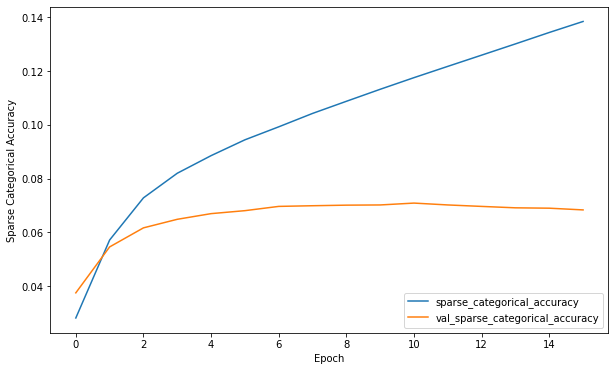

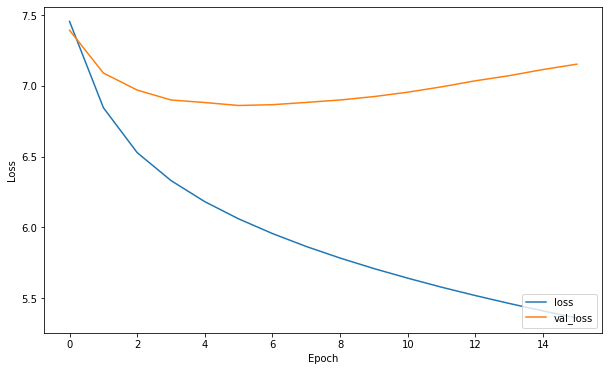

In [17]:
fig = plt.figure(figsize=(10, 6))
plt.plot(history.history['sparse_categorical_accuracy'], label='sparse_categorical_accuracy')
plt.plot(history.history['val_sparse_categorical_accuracy'], label='val_sparse_categorical_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Sparse Categorical Accuracy')
plt.legend(loc='lower right')
plt.show()
fig.savefig(str(model_dir / f'sparse_categorical_accuracy.png'), dpi=fig.dpi)

fig = plt.figure(figsize=(10, 6))
plt.plot(history.history['loss'], label='loss')
plt.plot(history.history['val_loss'], label='val_loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(loc='lower right')
plt.show()
fig.savefig(str(model_dir / f'sparse_categorical_loss.png'), dpi=fig.dpi)

Finally we evaluate the model on test data with batch size of 1024

In [18]:
model.evaluate(X_test, y_test, batch_size=1024)

544/544 [==============================] - 31s 58ms/step - loss: 7.2226 - sparse_categorical_accuracy: 0.0692


[7.222592353820801, 0.06924054026603699]

## Testing the model with actual data

`predict_next_words` function takes model, tokenizer and text as function argument and returns top 5 next words predicted by the model

In [123]:
def predict_next_words(model, tokenizer, text):
    # tokenize the text
    tokenized_sequence = tokenizer.texts_to_sequences([text])
    # pre-pad with 0's to make it of size MAX_SEQUENCE_LENGTH - 1
    input_sequences = tf.keras.preprocessing.sequence.pad_sequences(tokenized_sequence,
                                                                maxlen=MAX_SEQUENCE_LENGTH - 1,
                                                                padding='pre')
    # predict using model
    predictions = model.predict(input_sequences)
    ids = np.argsort(predictions, axis=1)[:,-5:] # indices of the top 5 predictions
    # print next word with score
    for id in ids[0]:
        print(tokenizer.index_word[id], "->", predictions[:, id].squeeze())

Test for custom texts by calling the function

In [127]:
text = input("Enter text: ")
predict_next_words(model, tokenizer, text)

Enter text:কেমন আছে
সে -> 0.017110024
কিন্তু -> 0.017308354
তেমনই -> 0.023750454
জানি -> 0.03365408
তেমনি -> 0.05967974
